In [1]:
import copy
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Neural Program Induction: Conway's Game of Life

Conway's Game consists of checking the neighbors and updating the life phase. The experiments gradually evolve by adding more constraints on update_life.

In [2]:
def check_neighbours(life, x_coord, y_coord):
    max_x, max_y = len(life), len(life[0])
    c = 0
    for x,y in [(x_coord+i,y_coord+j) for i in (-1,0,1) for j in (-1,0,1) if i != 0 or j != 0]:
        if 0 <= x < max_x and 0 <= y < max_y:
            if life[x][y]:
                c += 1
    return c

In [3]:
def update_life(life, n):
    new_life = copy.deepcopy(life)
    for r, row in enumerate(life):
        for c, val in enumerate(row):
            n_neig = check_neighbours(life, r, c)
            # This part changes at each experiment. 
            # First experiment: predict n. 
            if n_neig < n :
                new_life[r][c] = 0
    return new_life

In [4]:
# The checkerboard that we will use for our experiments.
def renew_life():
    life = [[0, 0, 1, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1]]
    return life

In [5]:
n = 3 # number of neighbors
life = renew_life()
print("Before: \n", np.matrix(life))
for i in range(5):
    new_life = update_life(life, n)
    print("Phase: ", i+1 ," \n", np.matrix(new_life))
    life = copy.deepcopy(life)

Before: 
 [[0 0 1 1 0 0 1 1]
 [1 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [1 0 0 1 1 0 1 1]]
Phase:  1  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  2  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  3  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  4  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  5  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]


### Train with a single in/out pair

First we train the feed forward neural network with the same pair of in-out phases. We can easily learn n after few steps.

In [6]:
life = renew_life()

In [7]:
life = renew_life()
N, M = len(life), len(life[0])

# Flatten the grids into vectors and concatenate. 
life_in = torch.FloatTensor(life).view(1, N*M)
new_life_in = torch.FloatTensor(new_life).view(1, N*M)
life_input = torch.cat((life_in, new_life_in), 1)

#print(life_in.view(1, 12))
print(life_input.shape)

input_dim = N*M*2
output_dim = 9

torch.Size([1, 64])


In [12]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([n])
print("target: ", target)

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

for t in range(1000):
    out = fc(life_input)

    loss = criterion(out, target)

    _, predicted = torch.max(out, 1)
    if predicted == n:
            print("STOP! Phase: ", t)
            break
    
    if t%200 == 0:
        print("Loss: ", loss)
        _, predicted = torch.max(out, 1)
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()

target:  tensor([3])
Loss:  tensor(2.3284, grad_fn=<NllLossBackward>)
STOP! Phase:  32


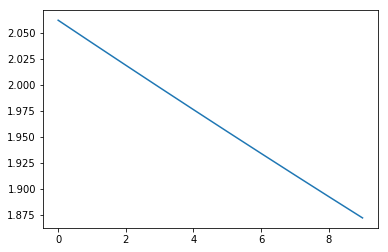

In [44]:
plt.plot(losses)

### Train with a life 

Now at each gradient descent step, introduce the pair of new phases updated by the rules.

In [49]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([n])

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

life = renew_life()

for t in range(201):
    
    # update life
    new_life = update_life(life, n)
    life_in = torch.FloatTensor(life).view(1, N*M)
    new_life_in = torch.FloatTensor(new_life).view(1, N*M)
    life_input = torch.cat((life_in, new_life_in), 1)
    
    out = fc(life_input)
    loss = criterion(out, target)

    _, predicted = torch.max(out, 1)
    if predicted == n:
            print("STOP! ", t)
            break
    
    if t%200 == 0:
        print(loss)
        print(predicted)
        
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    life = copy.deepcopy(life)

tensor(2.8135, grad_fn=<NllLossBackward>)
tensor([7])
STOP!  47


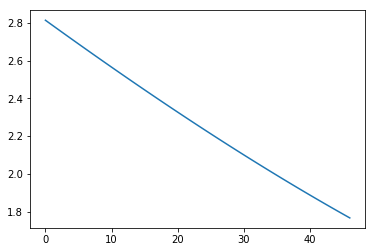

In [50]:
plt.plot(losses)

# Second Experiment

Introduce two variables in update rule to be predicted.

In [65]:
def update_life(life, m, n):
    new_life = copy.deepcopy(life)
    for r, row in enumerate(life):
        for c, val in enumerate(row):
            n_neig = check_neighbours(life, r, c)
            # This part changes at each experiment. 
            if n_neig != m and n_neig != n:
                new_life[r][c] = 0
                
    return new_life

In [66]:
m = 2 
n = 3

In [67]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
target = torch.zeros((1,9))
target[0,m]=1
target[0,n]=1

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

life = renew_life()

for t in range(1000):
    
    # update life
    new_life = update_life(life, m, n)
    life_in = torch.FloatTensor(life).view(1, N*M)
    new_life_in = torch.FloatTensor(new_life).view(1, N*M)
    life_input = torch.cat((life_in, new_life_in), 1)
    
    out = fc(life_input)
    #print(out)
    loss = criterion(out, target)

    pred = torch.zeros_like(target)
    ind = torch.topk(out, 2)[1][0]
    pred[0, ind[0]]=1
    pred[0, ind[1]]=1
    if torch.all(torch.eq(pred, target)):
        print("STOP! ", t)
        break
        
    if t%50 == 0:
        print("loss: ", loss)
        print("pred: ", ind)
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    life = copy.deepcopy(life)

ValueError: Target size (torch.Size([1, 9])) must be the same as input size (torch.Size([1, 13]))

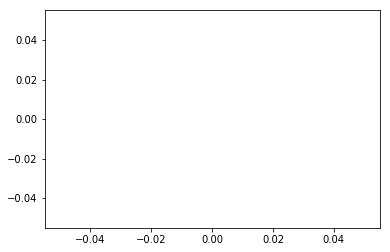

In [68]:
plt.plot(losses)

# Third Experiment

Introduce a variable and a logical operation with update rule to be predicted. 

Enumerate the operation variable as:

    10 -> "<"
    11 -> "="
    12 -> ">"

In [69]:
def update_life(life, n, op):
    new_life = copy.deepcopy(life)
    for r, row in enumerate(life):
        for c, val in enumerate(row):
            n_neig = check_neighbours(life, r, c)
            # This part changes at each experiment.
            if op == 10 and n_neig < n:
                new_life[r][c] = 0
            elif op == 11 and n_neig == n:
                new_life[r][c] = 0
            elif op == 12 and n_neig > n:
                new_life[r][c] = 0
    return new_life

In [70]:
n=3
op=12
output_dim = 13

In [71]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
target = torch.zeros((1,output_dim))
target[0,n]=1
target[0,op]=1

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []
life = renew_life()

for t in range(1000):
    
    # update life
    new_life = update_life(life, n, op)
    life_in = torch.FloatTensor(life).view(1, N*M)
    new_life_in = torch.FloatTensor(new_life).view(1, N*M)
    life_input = torch.cat((life_in, new_life_in), 1)
    
    out = fc(life_input)
    #print(out)
    loss = criterion(out, target)

    pred = torch.zeros_like(target)
    ind = torch.topk(out, 2)[1][0]
    pred[0, ind[0]]=1
    pred[0, ind[1]]=1
    if torch.all(torch.eq(pred, target)):
        print("STOP! t: ", t)
        print("   pred: ", ind)
        
        break
        
    if t%50 == 0:
        print("Iteration t: ", t, " loss: ", loss)
        print("       pred: ", ind)
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    life = copy.deepcopy(life)

Iteration t:  0  loss:  tensor(0.7491, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([5, 7])
Iteration t:  50  loss:  tensor(0.7151, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([5, 7])
Iteration t:  100  loss:  tensor(0.6831, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([ 5, 12])
Iteration t:  150  loss:  tensor(0.6530, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([ 5, 12])
Iteration t:  200  loss:  tensor(0.6247, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([ 5, 12])
Iteration t:  250  loss:  tensor(0.5980, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([ 5, 12])
Iteration t:  300  loss:  tensor(0.5729, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([ 5, 12])
Iteration t:  350  loss:  tensor(0.5494, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([12,  5])
Iteration t:  400  loss:  tensor(0.5272, grad_f

# Fourth Experiment

Now, try to predict if a rule is about death or birth.
Enumerate the condition variables as:

    13 -> die out
    14 -> become alive

In [72]:
def update_life(life, n, cond):
    new_life = copy.deepcopy(life)
    for r, row in enumerate(life):
        for c, val in enumerate(row):
            n_neig = check_neighbours(life, r, c)
            # This part changes at each experiment.
            if n_neig<n:
                if cond==13 and life[r][c]==0:
                    new_life[r][c]= 1
                elif cond==14 and life[r][c]==1:
                    new_life[r][c]= 0
    return new_life

In [73]:
cond = 14
n = 3
output_dim = 15

In [75]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
target = torch.zeros((1,output_dim))
target[0,n]=1
target[0,cond]=1

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

life = renew_life()

for t in range(1000):
    
    # update life
    new_life = update_life(life, n, cond)
    life_in = torch.FloatTensor(life).view(1, N*M)
    new_life_in = torch.FloatTensor(new_life).view(1, N*M)
    life_input = torch.cat((life_in, new_life_in), 1)
    
    out = fc(life_input)
    #print(out)
    loss = criterion(out, target)

    pred = torch.zeros_like(target)
    ind = torch.topk(out, 2)[1][0]
    pred[0, ind[0]]=1
    pred[0, ind[1]]=1
    if torch.all(torch.eq(pred, target)):
        print("STOP! t: ", t)
        print("   pred: ", ind)
        
        break
        
    if t%50 == 0:
        print("Iteration t: ", t, " loss: ", loss)
        print("       pred: ", ind)
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    life = copy.deepcopy(life)

Iteration t:  0  loss:  tensor(0.7877, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([2, 6])
Iteration t:  50  loss:  tensor(0.7635, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([2, 6])
Iteration t:  100  loss:  tensor(0.7404, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([2, 6])
Iteration t:  150  loss:  tensor(0.7181, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([2, 6])
Iteration t:  200  loss:  tensor(0.6967, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([2, 6])
Iteration t:  250  loss:  tensor(0.6762, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([2, 6])
Iteration t:  300  loss:  tensor(0.6565, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([14,  2])
Iteration t:  350  loss:  tensor(0.6375, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([14,  2])
Iteration t:  400  loss:  tensor(0.6193, grad_fn=<Binar

# Fifth Experiment

Now, combine 3rd and 4th experiments.
Enumerate the condition variables as:

    10 -> "<"
    11 -> "="
    12 -> ">"
    13 -> die out
    14 -> become alive

In [76]:
def update_life(life, n, op, cond):
    new_life = copy.deepcopy(life)
    for r, row in enumerate(life):
        for c, val in enumerate(row):
            n_neig = check_neighbours(life, r, c)
            # This part changes at each experiment.
            if cond == 14 and life[r][c]==0:
                if op == 10 and n_neig < n:
                    new_life[r][c] = 1
                elif op == 11 and n_neig == n:
                    new_life[r][c] = 1
                elif op == 12 and n_neig > n:
                    new_life[r][c] = 1
            elif cond == 13 and life[r][c]==1:
                if op == 10 and n_neig < n:
                    new_life[r][c] = 0
                elif op == 11 and n_neig == n:
                    new_life[r][c] = 0
                elif op == 12 and n_neig > n:
                    new_life[r][c] = 0
    return new_life

In [77]:
cond = 14
n = 3
op = 10
output_dim = 15

In [78]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
target = torch.zeros((1,output_dim))
target[0,n]=1
target[0,op]=1
target[0,cond]=1

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

for t in range(1000):
    
    # update life
    new_life = update_life(life, n, op, cond)
    life_in = torch.FloatTensor(life).view(1, N*M)
    new_life_in = torch.FloatTensor(new_life).view(1, N*M)
    life_input = torch.cat((life_in, new_life_in), 1)
    
    out = fc(life_input)
    #print(out)
    loss = criterion(out, target)

    pred = torch.zeros_like(target)
    ind = torch.topk(out, 3)[1][0]
    pred[0, ind[0]]=1
    pred[0, ind[1]]=1
    pred[0, ind[2]]=1
    if torch.all(torch.eq(pred, target)):
        print("STOP! t: ", t)
        print("   pred: ", ind)
        
        break
        
    if t%50 == 0:
        print("Iteration t: ", t, " loss: ", loss)
        print("       pred: ", ind)
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    life = copy.deepcopy(life)

Iteration t:  0  loss:  tensor(0.6781, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([4, 7, 0])
Iteration t:  50  loss:  tensor(0.6483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([4, 7, 0])
Iteration t:  100  loss:  tensor(0.6202, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([4, 7, 0])
Iteration t:  150  loss:  tensor(0.5938, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([ 4,  7, 10])
Iteration t:  200  loss:  tensor(0.5690, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
       pred:  tensor([10,  4,  7])
STOP! t:  228
   pred:  tensor([10, 14,  3])
